#　回帰分析

In [1]:
from IPython.core.display import display

from os import path
import re
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

#データの保存場所を指定
# この場所は、C:sample/linear_regression/を読み書きする。
WORK_DIR = 'D:\DEV\workspace\stock_trade\linear_regression'
DATA_DIR = 'D:\DEV\workspace\stock_trade\linear_regression\data'
DATA_CHAPTER1 = 'D:\DEV\workspace\stock_trade\data'

daily_data = pd.read_pickle(f"{DATA_CHAPTER1}\daily_data.pickle")

In [2]:
daily_data

,SC,名称,市場,業種,日付,株価,前日比,前日比（％）,前日終値,始値,...,PER（予想）,PBR（実績）,EPS（予想）,BPS（実績）,最低購入額,単元株,高値日付,年初来高値,安値日付,年初来安値
0,1,日経平均株価（日経225）,東証,株価指数,20210203,28646.50,284.33,1.00,28362.17,28482.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN
1,2,TOPIX（東証株価指数）,東証,株価指数,20210203,1871.09,24.07,1.30,1847.02,1858.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN
2,1301,極洋,東証一部,水産・農林,20210203,3055.00,30.00,0.99,3025.00,3030.00,...,10.95,0.94,279.08,3256.77,305500.0,100.0,2021-01-19,3145.0,2020-03-13,2202.0
3,1332,日本水産,東証一部,水産・農林,20210203,453.00,11.00,2.49,442.00,442.00,...,12.26,0.89,36.96,510.15,45300.0,100.0,2020-01-07,639.0,2020-03-13,398.0
4,1333,マルハニチロ,東証一部,水産・農林,20210203,2395.00,47.00,2.00,2348.00,2351.00,...,19.69,0.92,121.62,2603.98,239500.0,100.0,2020-01-17,2780.0,2020-03-13,1846.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024557,9993,ヤマザワ,東証一部,小売,20210202,1737.00,-5.00,-0.29,1742.00,1740.00,...,27.05,0.65,64.22,2659.67,173700.0,100.0,2020-10-09,1892.0,2020-03-13,1121.0
1024558,9994,やまや,東証一部,小売,20210202,2171.00,8.00,0.37,2163.00,2169.00,...,523.13,0.74,4.15,2917.68,217100.0,100.0,2020-06-23,2450.0,2020-03-17,1821.0
1024559,9995,グローセル,東証一部,卸売,20210202,500.00,-4.00,-0.79,504.00,502.00,...,NaN,0.55,-10.13,915.74,50000.0,100.0,2021-01-27,550.0,2020-04-06,317.0
1024560,9996,サトー商会,JQS,卸売,20210202,1499.00,-10.00,-0.66,1509.00,1500.00,...,31.91,0.57,46.98,2648.72,149900.0,100.0,2020-01-10,1736.0,2020-04-06,1310.0


In [3]:
#銘柄ごとに計算するため、証券コード（SC)で集計する
groups = daily_data.groupby('SC')

data_set = []
for security, values in tqdm(groups):
    #全体の10％以上の取引日で取引のない銘柄は無視する
    if values['株価'].isnull().sum() > values.shape[0] * 0.1:
        continue
    
    #一時的にmarket_value列を作って計算する
    #証券コード（SC)１，２は株価指数を表しているので、単純に指数値を入れる。
    if security in {1,2}:
        values = values.assign(market_value = lambda x:x['株価'])
    else:
        values = values.assign(market_value = lambda x:x['時価総額（百万円）'])
    #calculate return
    values = values.sort_values('日時') #時系列順でソート
    values['収益率'] = values['market_value'].pct_change() #変化率の計算
    values.drop(columns = ['market_value']) #一時的な列を削除
    data_set.append(values)
    
daily_data_adj = pd.concat(data_set) #銘柄ごとに計算したものを結合

#極端な値を外れ値として削除。ここでは上下0.1%を外れ値とする
threehold = .001

lower = daily_data_adj['収益率'].quantile(threehold)
upper = daily_data_adj['収益率'].quantile(1-threehold)

daily_data_adj = daily_data_adj[
    (lower < daily_data_adj['収益率']) & (daily_data_adj['収益率'] < upper)
].copy()
    

C:/Users/masa/AppData/Local/Temp/xpython_35500/2253177641.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for security, values in tqdm(groups):


  0%|          | 0/3976 [00:00<?, ?it/s]

In [4]:
jgb_path = f'{DATA_DIR}\\risk_free_rate\jgbcm_all.csv'
risk_free_rate = pd.read_csv(
    jgb_path,
    skiprows = 1,
    usecols = ['基準日','10年'],
    parse_dates = ['基準日'],
    encoding = 'sjis',
    index_col = ['基準日'],
    na_values = '-'
)


In [5]:

risk_free_rate

,10年
基準日,
1974-09-24,NaN
1974-09-25,NaN
1974-09-26,NaN
1974-09-27,NaN
1974-09-28,NaN
...,...
2021-11-24,0.091
2021-11-25,0.090
2021-11-26,0.079


In [6]:
risk_free_rate = risk_free_rate.apply(
    #半年福利（％表記）を日時対数収益率に変換
    lambda x: np.log(1 + .01 * .5 * x) / 125
).apply(
    #単利へ変換
    lambda x: np.exp(x) - 1
)

risk_free_rate

risk_free_rate
risk_free_rate.rename(columns={'10年': '安全資産利子率'}, inplace=True)
risk_free_rate.index.rename('日時', inplace=True)

risk_free_rate = pd.DataFrame(risk_free_rate)

#出力して結果を確認
display(risk_free_rate.dropna().head())

,安全資産利子率
日時,
1986-07-05,0.000202
1986-07-07,0.000201
1986-07-08,0.000202
1986-07-09,0.000203
1986-07-10,0.000203


In [7]:
stock_return_and_risk_free_return = pd.merge(
    daily_data_adj[daily_data_adj['SC']>2], #指数を除く
    risk_free_rate, 
    on=['日時'],
    how = 'left'
)

#SCと日時をindexにする
stock_return_and_risk_free_return.set_index(
    ['SC','日時'],
    verify_integrity = True,
    inplace = True
)

#出力して結果を確認
display(stock_return_and_risk_free_return.head())

名称    市場     業種        日付      株価   前日比  前日比（％）    前日終値  \
SC   日時                                                                    
1301 2020-12-02  極洋  東証一部  水産・農林  20201202  2811.0  24.0    0.86  2787.0   
     2020-12-03  極洋  東証一部  水産・農林  20201203  2807.0  -4.0   -0.14  2811.0   
     2020-12-04  極洋  東証一部  水産・農林  20201204  2811.0   4.0    0.14  2807.0   
     2020-12-07  極洋  東証一部  水産・農林  20201207  2811.0   0.0    0.00  2811.0   
     2020-12-08  極洋  東証一部  水産・農林  20201208  2816.0   5.0    0.18  2811.0   

                     始値      高値  ...  BPS（実績）     最低購入額    単元株       高値日付  \
SC   日時                          ...                                        
1301 2020-12-02  2806.0  2817.0  ...  3256.77  281100.0  100.0 2020-01-21   
     2020-12-03  2810.0  2816.0  ...  3256.77  280700.0  100.0 2020-01-21   
     2020-12-04  2819.0  2819.0  ...  3256.77  281100.0  100.0 2020-01-21   
     2020-12-07  2820.0  2830.0  ...  3256.77  281100.0  100.0 2020-01-21   
     2020-12-08  2807.0  2824.0  ...  3256.77  281600.0  100.0 2020-01-21   

                  年初来高値       安値日付   年初来安値  market_value       収益率  \
SC   日時                                                              
1301 2020-12-02  2950.0 2020-03-13  2202.0       30719.0  0.008602   
     2020-12-03  2950.0 2020-03-13  2202.0       30676.0 -0.001400   
     2020-12-04  2950.0 2020-03-13  2202.0       30719.0  0.001402   
     2020-12-07  2950.0 2020-03-13  2202.0       30719.0  0.000000   
     2020-12-08  2950.0 2020-03-13  2202.0       30774.0  0.001790   

                      安全資産利子率  
SC   日時                        
1301 2020-12-02  1.159917e-06  
     2020-12-03  1.119922e-06  
     2020-12-04  1.159917e-06  
     2020-12-07  1.159917e-06  
     2020-12-08  9.199475e-07  

[5 rows x 32 columns]

In [8]:
# 日時で集計
group_by_date = stock_return_and_risk_free_return.groupby('日時')

data_with_market_returns = []
for data, values in tqdm(group_by_date):
    sum_of_market_capital = values['時価総額（百万円）'].sum()
    values = values.assign(
        #returnがすべてnullならnullにする
        市場収益率 = lambda x: (
            x['収益率'] * (x['時価総額（百万円）'] / sum_of_market_capital)
        ).sum(
            min_count = 1
        )
    )
    data_with_market_returns.append(values)
    
data_with_market_returns = pd.concat(data_with_market_returns)

display(data_with_market_returns.head())

C:/Users/masa/AppData/Local/Temp/xpython_35500/1054381476.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data, values in tqdm(group_by_date):


  0%|          | 0/266 [00:00<?, ?it/s]

,,名称,市場,業種,日付,株価,前日比,前日比（％）,前日終値,始値,高値,...,最低購入額,単元株,高値日付,年初来高値,安値日付,年初来安値,market_value,収益率,安全資産利子率,市場収益率
SC,日時,,,,,,,,,,,,,,,,,,,,,
1301,2020-12-02,極洋,東証一部,水産・農林,20201202,2811.0,24.0,0.86,2787.0,2806.0,2817.0,...,281100.0,100.0,2020-01-21,2950.0,2020-03-13,2202.0,30719.0,0.008602,0.000001,0.002711
1332,2020-12-02,日本水産,東証一部,水産・農林,20201202,418.0,9.0,2.20,409.0,410.0,420.0,...,41800.0,100.0,2020-01-07,639.0,2020-03-13,398.0,130596.0,0.022006,0.000001,0.002711
1333,2020-12-02,マルハニチロ,東証一部,水産・農林,20201202,2167.0,37.0,1.74,2130.0,2125.0,2168.0,...,216700.0,100.0,2020-01-17,2780.0,2020-03-13,1846.0,114108.0,0.017377,0.000001,0.002711
1352,2020-12-02,ホウスイ,東証一部,卸売,20201202,1007.0,18.0,1.82,989.0,1000.0,1010.0,...,100700.0,100.0,2020-11-17,1038.0,2020-03-16,633.0,8438.0,0.018221,0.000001,0.002711
1375,2020-12-02,雪国まいたけ,東証一部,水産・農林,20201202,1813.0,-7.0,-0.38,1820.0,1828.0,1832.0,...,181300.0,100.0,2020-10-28,2173.0,2020-11-19,1701.0,72248.0,-0.003847,0.000001,0.002711


In [9]:
data_with_excess_returns = data_with_market_returns.assign(
    超過収益率 = lambda x: x['収益率'] - x['安全資産利子率'],
    市場超過収益率 = lambda x: x['市場収益率'] - x['安全資産利子率']
)

In [10]:
# 扱いやすくするためにindexを通常の列に戻す
temporary_data_excess_returns = data_with_excess_returns.reset_index()

#read financial data
financial_data = pd.read_pickle(
    f'{DATA_CHAPTER1}\\financial_data_all.pickle'
)

#利用しない列を削除
financial_data.drop(
    columns = ['発行済株式数', '日時'],
    inplace = True
)

# 決算発表当日の株価データとマージできるように、株価データに決算発表日を張る
group_by_security = temporary_data_excess_returns.groupby('SC')


In [11]:
financial_data

,SC,名称,決算期,売上高（百万円）,営業利益（百万円）,経常利益（百万円）,当期利益（百万円）,総資産（百万円）,自己資本（百万円）,資本金（百万円）,有利子負債（百万円）,自己資本比率,ROE,ROA,決算発表日（本決算）
0,1301,極洋,202003.0,262519.0,2918.0,3608.0,2037.0,111184.0,32718.0,5664.0,54718.0,29.4,6.31,1.80,2020-05-12
1,1332,日本水産,202003.0,690016.0,22834.0,25807.0,14768.0,491533.0,153152.0,30685.0,221238.0,31.2,9.86,3.05,2020-05-20
2,1333,マルハニチロ,202003.0,905204.0,17079.0,19901.0,12537.0,528063.0,132628.0,20000.0,261714.0,25.1,9.72,2.39,2020-05-14
3,1352,ホウスイ,202003.0,80492.0,839.0,757.0,454.0,40128.0,6368.0,2485.0,24275.0,15.9,7.29,1.11,2020-05-15
4,1375,雪国まいたけ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.9,120.57,11.85,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3819,9993,ヤマザワ,202002.0,109709.0,627.0,698.0,-220.0,50284.0,28147.0,2388.0,5116.0,56.0,-0.77,-0.44,2020-04-10
3820,9994,やまや,202003.0,168168.0,4163.0,4227.0,205.0,63320.0,31925.0,3247.0,6361.0,50.4,0.64,0.30,2020-06-24
3821,9995,グローセル,202003.0,68664.0,-61.0,5.0,65.0,32061.0,22550.0,5042.0,1935.0,70.3,0.28,0.20,2020-05-14
3822,9996,サトー商会,202003.0,49562.0,1437.0,1659.0,1037.0,32271.0,23710.0,1405.0,683.0,73.5,4.44,3.12,2020-05-13


In [12]:

temporary_list = []
for security, values in tqdm(group_by_security):
    #財務データから決算発表日を取得
    #例: array(
    #       ['2016-05-11T00:00:00.00000000', '2017-05-11T00:00:00.000000000]'
    #       dtype = 'datetime64[ns]'
    #     )
    announcement_dates = financial_data[
        '決算発表日（本決算）'
    ][
        financial_data.SC ==security
    ].dropna().unique()
    #古い順にソートしてnp.arrayに戻す
    announcement_dates = pd.Series(announcement_dates).sort_values().values
    
    #収益率データの「日時」が含まれる決算期を意味するカテゴリ狩る変数を作る、
    #例:「日時」が2016-05-11より前→欠損地、
    #   「日時」が2016-05-11～　2017-05-10 →2016-05-11,など

    aligned = values.assign(
        announcement_date = lambda x: pd.cut(
            x['日時'],
            (
                    list(announcement_dates)
            ) + [np.datetime64(values['日時'].max() + pd.offsets.Day())],
            labels = announcement_dates,
            right= False
        ).astype(
            np.datetime64
        )
    )
    temporary_list.append(aligned)
    

    

C:/Users/masa/AppData/Local/Temp/xpython_35500/2934923392.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for security, values in tqdm(group_by_security):


  0%|          | 0/3750 [00:00<?, ?it/s]

In [13]:
temporary_data_excess_returns = pd.concat(temporary_list)
temporary_data_excess_returns.rename(
    columns = {'announcement_date':'決算発表日（日時）'},
    inplace = True
)
del temporary_list

In [14]:


#財務データを決算発表日について一意にする
financial_data = financial_data.groupby(
    ['SC','決算発表日（本決算）']
).first().reset_index()

excess_returns_with_financial_data = pd.merge(
    temporary_data_excess_returns,
    financial_data,
    left_on = ['SC','名称','決算発表日（日時）'],
    right_on = ['SC','名称','決算発表日（本決算）'],
    how='left'
)
excess_returns_with_financial_data.set_index(
    ['SC','日時'],
    inplace=True,
    verify_integrity=True
)

del temporary_data_excess_returns
    

In [15]:
excess_returns_with_financial_data

名称    市場     業種        日付      株価   前日比  前日比（％）    前日終値  \
SC   日時                                                                      
1301 2020-12-02    極洋  東証一部  水産・農林  20201202  2811.0  24.0    0.86  2787.0   
     2020-12-03    極洋  東証一部  水産・農林  20201203  2807.0  -4.0   -0.14  2811.0   
     2020-12-04    極洋  東証一部  水産・農林  20201204  2811.0   4.0    0.14  2807.0   
     2020-12-07    極洋  東証一部  水産・農林  20201207  2811.0   0.0    0.00  2811.0   
     2020-12-08    極洋  東証一部  水産・農林  20201208  2816.0   5.0    0.18  2811.0   
...               ...   ...    ...       ...     ...   ...     ...     ...   
9997 2021-12-24  ベルーナ  東証一部     小売  20211224   679.0   4.0    0.59   675.0   
     2021-12-27  ベルーナ  東証一部     小売  20211227   674.0  -5.0   -0.74   679.0   
     2021-12-28  ベルーナ  東証一部     小売  20211228   687.0  13.0    1.93   674.0   
     2021-12-29  ベルーナ  東証一部     小売  20211229   714.0  27.0    3.93   687.0   
     2021-12-30  ベルーナ  東証一部     小売  20211230   709.0  -5.0   -0.70   714.0   

                     始値      高値  ...  営業利益（百万円）  経常利益（百万円）  当期利益（百万円）  \
SC   日時                          ...                                    
1301 2020-12-02  2806.0  2817.0  ...     2918.0     3608.0     2037.0   
     2020-12-03  2810.0  2816.0  ...     2918.0     3608.0     2037.0   
     2020-12-04  2819.0  2819.0  ...     2918.0     3608.0     2037.0   
     2020-12-07  2820.0  2830.0  ...     2918.0     3608.0     2037.0   
     2020-12-08  2807.0  2824.0  ...     2918.0     3608.0     2037.0   
...                 ...     ...  ...        ...        ...        ...   
9997 2021-12-24   670.0   690.0  ...    15734.0    16872.0    11036.0   
     2021-12-27   680.0   680.0  ...    15734.0    16872.0    11036.0   
     2021-12-28   680.0   690.0  ...    15734.0    16872.0    11036.0   
     2021-12-29   691.0   714.0  ...    15734.0    16872.0    11036.0   
     2021-12-30   714.0   716.0  ...    15734.0    16872.0    11036.0   

                 総資産（百万円）  自己資本（百万円）  資本金（百万円）  有利子負債（百万円）  自己資本比率    ROE  \
SC   日時                                                                     
1301 2020-12-02  111184.0    32718.0    5664.0     54718.0    29.4   6.31   
     2020-12-03  111184.0    32718.0    5664.0     54718.0    29.4   6.31   
     2020-12-04  111184.0    32718.0    5664.0     54718.0    29.4   6.31   
     2020-12-07  111184.0    32718.0    5664.0     54718.0    29.4   6.31   
     2020-12-08  111184.0    32718.0    5664.0     54718.0    29.4   6.31   
...                   ...        ...       ...         ...     ...    ...   
9997 2021-12-24  240211.0   112620.0   10612.0     72706.0    46.9  10.29   
     2021-12-27  240211.0   112620.0   10612.0     72706.0    46.9  10.29   
     2021-12-28  240211.0   112620.0   10612.0     72706.0    46.9  10.29   
     2021-12-29  240211.0   112620.0   10612.0     72706.0    46.9  10.29   
     2021-12-30  240211.0   112620.0   10612.0     72706.0    46.9  10.29   

                  ROA  
SC   日時                
1301 2020-12-02  1.80  
     2020-12-03  1.80  
     2020-12-04  1.80  
     2020-12-07  1.80  
     2020-12-08  1.80  
...               ...  
9997 2021-12-24  4.76  
     2021-12-27  4.76  
     2021-12-28  4.76  
     2021-12-29  4.76  
     2021-12-30  4.76  

[960897 rows x 49 columns]

In [16]:
#データをpickleで保存
excess_returns_with_financial_data.to_pickle(
    f'{DATA_DIR}\\excess_returns_with_financial_data.pickle'
)

#　説明変数の準備
以下回帰分析２に記述

In [17]:
from IPython.core.display import display
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook as tqdm

from sklearn import linear_model,preprocessing
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Yu Mincho'

#データの保存場所を指定
#この場合は、D:\DEV\workspace\stock_trade\linear_regressionを読み書きする。
WORK_DIR = 'D:\DEV\workspace\stock_trade\linear_regression'

data = pd.read_pickle(f'{DATA_DIR}\excess_returns_with_financial_data.pickle')

In [18]:
#対数変換で正規分布に近づける
def correct_skewness(series):
    if series.min() <= 0:
        series += series.min() + 1
        
    corrected = np.log(series)
    
    return corrected
    
# 標準化して変数のスケールを合わせる
def standardize_characteristics(series):
    series = series.dropna()
    standardized = stats.zscore(series)
    
    return pd.Series(standardized, index = series.index)

# winsorizeによる外れ値の処理
def trim_outliers(series, limits = .01):
    series = series.dropna()
    trimmed = stats.mstats.winsorize(series, limits=limits)
    
    return pd.Series(trimmed, index = series.index)
                               

In [19]:
data

名称    市場     業種        日付      株価   前日比  前日比（％）    前日終値  \
SC   日時                                                                      
1301 2020-12-02    極洋  東証一部  水産・農林  20201202  2811.0  24.0    0.86  2787.0   
     2020-12-03    極洋  東証一部  水産・農林  20201203  2807.0  -4.0   -0.14  2811.0   
     2020-12-04    極洋  東証一部  水産・農林  20201204  2811.0   4.0    0.14  2807.0   
     2020-12-07    極洋  東証一部  水産・農林  20201207  2811.0   0.0    0.00  2811.0   
     2020-12-08    極洋  東証一部  水産・農林  20201208  2816.0   5.0    0.18  2811.0   
...               ...   ...    ...       ...     ...   ...     ...     ...   
9997 2021-12-24  ベルーナ  東証一部     小売  20211224   679.0   4.0    0.59   675.0   
     2021-12-27  ベルーナ  東証一部     小売  20211227   674.0  -5.0   -0.74   679.0   
     2021-12-28  ベルーナ  東証一部     小売  20211228   687.0  13.0    1.93   674.0   
     2021-12-29  ベルーナ  東証一部     小売  20211229   714.0  27.0    3.93   687.0   
     2021-12-30  ベルーナ  東証一部     小売  20211230   709.0  -5.0   -0.70   714.0   

                     始値      高値  ...  営業利益（百万円）  経常利益（百万円）  当期利益（百万円）  \
SC   日時                          ...                                    
1301 2020-12-02  2806.0  2817.0  ...     2918.0     3608.0     2037.0   
     2020-12-03  2810.0  2816.0  ...     2918.0     3608.0     2037.0   
     2020-12-04  2819.0  2819.0  ...     2918.0     3608.0     2037.0   
     2020-12-07  2820.0  2830.0  ...     2918.0     3608.0     2037.0   
     2020-12-08  2807.0  2824.0  ...     2918.0     3608.0     2037.0   
...                 ...     ...  ...        ...        ...        ...   
9997 2021-12-24   670.0   690.0  ...    15734.0    16872.0    11036.0   
     2021-12-27   680.0   680.0  ...    15734.0    16872.0    11036.0   
     2021-12-28   680.0   690.0  ...    15734.0    16872.0    11036.0   
     2021-12-29   691.0   714.0  ...    15734.0    16872.0    11036.0   
     2021-12-30   714.0   716.0  ...    15734.0    16872.0    11036.0   

                 総資産（百万円）  自己資本（百万円）  資本金（百万円）  有利子負債（百万円）  自己資本比率    ROE  \
SC   日時                                                                     
1301 2020-12-02  111184.0    32718.0    5664.0     54718.0    29.4   6.31   
     2020-12-03  111184.0    32718.0    5664.0     54718.0    29.4   6.31   
     2020-12-04  111184.0    32718.0    5664.0     54718.0    29.4   6.31   
     2020-12-07  111184.0    32718.0    5664.0     54718.0    29.4   6.31   
     2020-12-08  111184.0    32718.0    5664.0     54718.0    29.4   6.31   
...                   ...        ...       ...         ...     ...    ...   
9997 2021-12-24  240211.0   112620.0   10612.0     72706.0    46.9  10.29   
     2021-12-27  240211.0   112620.0   10612.0     72706.0    46.9  10.29   
     2021-12-28  240211.0   112620.0   10612.0     72706.0    46.9  10.29   
     2021-12-29  240211.0   112620.0   10612.0     72706.0    46.9  10.29   
     2021-12-30  240211.0   112620.0   10612.0     72706.0    46.9  10.29   

                  ROA  
SC   日時                
1301 2020-12-02  1.80  
     2020-12-03  1.80  
     2020-12-04  1.80  
     2020-12-07  1.80  
     2020-12-08  1.80  
...               ...  
9997 2021-12-24  4.76  
     2021-12-27  4.76  
     2021-12-28  4.76  
     2021-12-29  4.76  
     2021-12-30  4.76  

[960897 rows x 49 columns]

In [20]:
data1 = data.astype(str)

In [21]:

group_by_date = data1.groupby('日時')

dataset_of_firm_size = []
dataset_of_firm_size1 = [] 
dataset_of_firm_size2 = [] 
dataset_of_firm_size3 = [] 
for date, value in group_by_date:
    market_value_of_equity = value['時価総額（百万円）'].astype(float)
    dataset_of_firm_size1.append(market_value_of_equity)
    market_value_of_equity = correct_skewness(
        market_value_of_equity
    )
    dataset_of_firm_size2.append(market_value_of_equity)
    market_value_of_equity = standardize_characteristics(
        market_value_of_equity
    )
    dataset_of_firm_size3.append(market_value_of_equity)
    market_value_of_equity = trim_outliers(
        market_value_of_equity
    )
    
    market_value_of_equity.name = '企業規模'
    
    dataset_of_firm_size.append(market_value_of_equity)
    
dataset_of_firm_size = pd.concat(dataset_of_firm_size)
    

In [22]:
dataset_of_firm_size1 = pd.concat(dataset_of_firm_size1)
dataset_of_firm_size2 = pd.concat(dataset_of_firm_size2)
dataset_of_firm_size3 = pd.concat(dataset_of_firm_size3)

(array([0.1098535 , 0.11922389, 0.21631065, 0.26536145, 0.34980325,
        0.36981598, 0.40698633, 0.45617245, 0.41430674, 0.39666199,
        0.40269693, 0.41681679, 0.35790171, 0.2934388 , 0.28575982,
        0.24291986, 0.20457228, 0.19167023, 0.15962822, 0.13648301,
        0.12734941, 0.09500294, 0.08570021, 0.08230386, 0.07521348,
        0.05243361, 0.03654116, 0.03617581, 0.0334222 , 0.0805448 ]),
 array([-1.7373231 , -1.5835023 , -1.4296815 , -1.2758607 , -1.1220399 ,
        -0.9682191 , -0.8143983 , -0.6605775 , -0.5067567 , -0.3529359 ,
        -0.19911509, -0.04529429,  0.10852651,  0.26234731,  0.41616811,
         0.56998891,  0.72380971,  0.87763051,  1.03145131,  1.18527211,
         1.33909291,  1.49291371,  1.64673451,  1.80055531,  1.95437611,
         2.10819691,  2.26201771,  2.41583851,  2.56965931,  2.72348011,
         2.87730091]),
 <BarContainer object of 30 artists>)

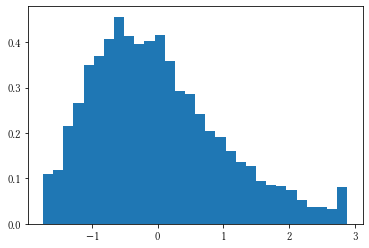

In [23]:
import matplotlib.pyplot as plt

plt.hist(dataset_of_firm_size, bins=30, density=True)

(array([8.28665247e-07, 1.35486980e-08, 6.62690569e-09, 2.98460963e-09,
        1.87029579e-09, 1.61830181e-09, 1.29124578e-09, 6.08538670e-10,
        1.90335884e-10, 2.49313200e-10, 2.06420606e-10, 1.84974309e-10,
        1.11699462e-10, 6.88068687e-11, 6.16581031e-11, 7.14876558e-11,
        8.93595697e-12, 2.41270838e-11, 2.14462967e-11, 3.57438279e-12,
        8.93595697e-12, 1.87655096e-11, 3.21694451e-11, 3.39566365e-11,
        1.07231484e-11, 5.36157418e-12, 1.07231484e-11, 6.25516988e-11,
        3.21694451e-11, 2.14462967e-11]),
 array([1.19000000e+02, 1.16473323e+06, 2.32934747e+06, 3.49396170e+06,
        4.65857593e+06, 5.82319017e+06, 6.98780440e+06, 8.15241863e+06,
        9.31703287e+06, 1.04816471e+07, 1.16462613e+07, 1.28108756e+07,
        1.39754898e+07, 1.51401040e+07, 1.63047183e+07, 1.74693325e+07,
        1.86339467e+07, 1.97985610e+07, 2.09631752e+07, 2.21277894e+07,
        2.32924037e+07, 2.44570179e+07, 2.56216321e+07, 2.67862464e+07,
        2.79508606e+07

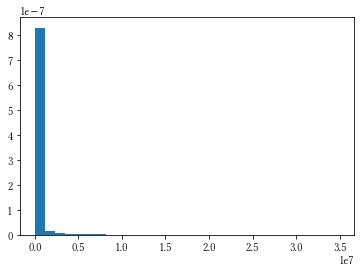

In [24]:
plt.hist(dataset_of_firm_size1, bins=30, density=True)


(array([2.47981598e-06, 2.23183438e-05, 7.43944794e-06, 1.25974652e-03,
        5.59446485e-03, 2.46444112e-02, 6.34039350e-02, 1.35891436e-01,
        1.94211748e-01, 2.17636090e-01, 2.54094345e-01, 2.28929172e-01,
        2.28110833e-01, 2.13685743e-01, 1.66452688e-01, 1.42616697e-01,
        1.15985953e-01, 9.04736063e-02, 7.51483435e-02, 5.68423419e-02,
        4.61196176e-02, 4.20254414e-02, 2.30300510e-02, 2.00319535e-02,
        1.53277426e-02, 1.04449849e-02, 7.24850211e-03, 2.19959678e-03,
        7.46424610e-04, 6.59631051e-04]),
 array([ 4.77912349,  5.19878942,  5.61845534,  6.03812127,  6.45778719,
         6.87745312,  7.29711904,  7.71678497,  8.13645089,  8.55611682,
         8.97578274,  9.39544867,  9.81511459, 10.23478052, 10.65444645,
        11.07411237, 11.4937783 , 11.91344422, 12.33311015, 12.75277607,
        13.172442  , 13.59210792, 14.01177385, 14.43143977, 14.8511057 ,
        15.27077162, 15.69043755, 16.11010347, 16.5297694 , 16.94943532,
        17.36910

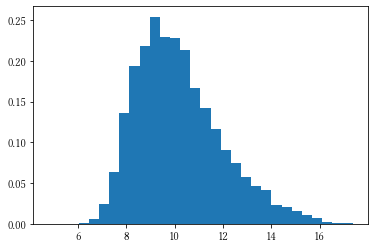

In [25]:
plt.hist(dataset_of_firm_size2, bins=30, density=True)

(array([4.37237475e-06, 3.93513727e-05, 1.31171242e-05, 1.77081177e-03,
        7.91399829e-03, 3.95699914e-02, 1.00722025e-01, 2.29763920e-01,
        3.32344204e-01, 3.82744568e-01, 4.44600554e-01, 4.12161905e-01,
        3.99250283e-01, 3.83697746e-01, 2.97986084e-01, 2.58778999e-01,
        2.05737721e-01, 1.64921603e-01, 1.34004541e-01, 1.02392272e-01,
        8.24848496e-02, 7.60749482e-02, 4.22808638e-02, 3.54730763e-02,
        2.76508979e-02, 1.89717340e-02, 1.32876469e-02, 4.15812838e-03,
        1.42976654e-03, 1.17179643e-03]),
 array([-3.09246506e+00, -2.85444926e+00, -2.61643346e+00, -2.37841766e+00,
        -2.14040186e+00, -1.90238606e+00, -1.66437026e+00, -1.42635447e+00,
        -1.18833867e+00, -9.50322868e-01, -7.12307069e-01, -4.74291270e-01,
        -2.36275471e-01,  1.74032790e-03,  2.39756127e-01,  4.77771926e-01,
         7.15787725e-01,  9.53803523e-01,  1.19181932e+00,  1.42983512e+00,
         1.66785092e+00,  1.90586672e+00,  2.14388252e+00,  2.38189832e+00

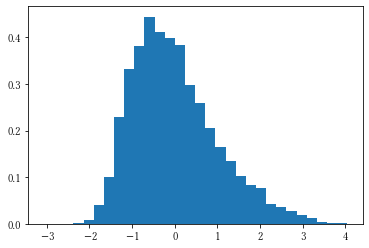

In [26]:
plt.hist(dataset_of_firm_size3, bins=30, density=True)

In [35]:
#plt.hist(list(group_by_date['時価総額（百万円）']), density=True)

簿価時価比率


In [154]:
group_by_date = data.groupby(level=1)

dataset_of_bm = []
for date, value in group_by_date:
    book_to_market = value['自己資本（百万円）'] /value['時価総額（百万円）']
    
    #自己資本がマイナスである銘柄を除去
    book_to_market = book_to_market[book_to_market >0]
    
    book_to_market = correct_skewness(book_to_market)
    book_to_market = standardize_characteristics(book_to_market)
    book_to_market = trim_outliers(book_to_market)
    
    book_to_market.name = '簿価時価比率'
    
    dataset_of_bm.append(book_to_market)
    
dataset_of_bm = pd.concat(dataset_of_bm)
    

財務レバレッジ

In [36]:
group_by_date = data.groupby(level=1)

dataset_of_leverage1 = []
for date, value in group_by_date:
    financial_leverage = value['総資産（百万円）'] /value['時価総額（百万円）']
    financial_leverage = correct_skewness(financial_leverage)
    financial_leverage = standardize_characteristics(financial_leverage)
    financial_leverage = trim_outliers(financial_leverage)
    
    financial_leverage.name = '財務レバレッジ'
    
    dataset_of_leverage1.append(financial_leverage)
    


In [37]:
dataset_of_leverage = []
dataset_of_leverage = pd.concat(dataset_of_leverage1)

(array([0.06107931, 0.02882972, 0.04662027, 0.06543469, 0.07910893,
        0.10618195, 0.13664364, 0.17399702, 0.23171364, 0.27748154,
        0.34154933, 0.40998809, 0.49270918, 0.45863013, 0.47939356,
        0.45238291, 0.37361181, 0.2534074 , 0.14432013, 0.07832933,
        0.04298212, 0.02106488, 0.00847688, 0.01164207, 0.00828978,
        0.00512459, 0.01378338, 0.01499956, 0.03627753, 0.04227528]),
 array([-2.61664711, -2.41241245, -2.20817779, -2.00394314, -1.79970848,
        -1.59547382, -1.39123917, -1.18700451, -0.98276985, -0.77853519,
        -0.57430054, -0.37006588, -0.16583122,  0.03840343,  0.24263809,
         0.44687275,  0.6511074 ,  0.85534206,  1.05957672,  1.26381138,
         1.46804603,  1.67228069,  1.87651535,  2.08075   ,  2.28498466,
         2.48921932,  2.69345398,  2.89768863,  3.10192329,  3.30615795,
         3.5103926 ]),
 <BarContainer object of 30 artists>)

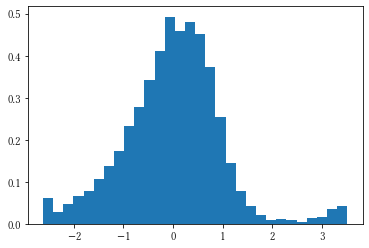

In [38]:
plt.hist(dataset_of_leverage, bins=30, density=True)

# 1/PER

In [39]:
group_by_date = data.groupby(level=1)

dataset_of_price_to_earnings = []
for date, value in group_by_date:
    earnings_over_market_equity = value[
        '当期利益（百万円）'
    ] / value['時価総額（百万円）']
    
    #自己資本がマイナスである銘柄を除去
    earnings_over_market_equity = earnings_over_market_equity[
        earnings_over_market_equity > 0
    ]
    
    earnings_over_market_equity = correct_skewness(
        earnings_over_market_equity
    )
    
    earnings_over_market_equity = standardize_characteristics(
        earnings_over_market_equity
    )
    
    earnings_over_market_equity = trim_outliers(
        earnings_over_market_equity
    )
    
    earnings_over_market_equity.name = 'E(+)/P'
    
    dataset_of_price_to_earnings.append(earnings_over_market_equity)
    
dataset_of_price_to_earnings = pd.concat(dataset_of_price_to_earnings)



(array([0.06107931, 0.02882972, 0.04662027, 0.06543469, 0.07910893,
        0.10618195, 0.13664364, 0.17399702, 0.23171364, 0.27748154,
        0.34154933, 0.40998809, 0.49270918, 0.45863013, 0.47939356,
        0.45238291, 0.37361181, 0.2534074 , 0.14432013, 0.07832933,
        0.04298212, 0.02106488, 0.00847688, 0.01164207, 0.00828978,
        0.00512459, 0.01378338, 0.01499956, 0.03627753, 0.04227528]),
 array([-2.61664711, -2.41241245, -2.20817779, -2.00394314, -1.79970848,
        -1.59547382, -1.39123917, -1.18700451, -0.98276985, -0.77853519,
        -0.57430054, -0.37006588, -0.16583122,  0.03840343,  0.24263809,
         0.44687275,  0.6511074 ,  0.85534206,  1.05957672,  1.26381138,
         1.46804603,  1.67228069,  1.87651535,  2.08075   ,  2.28498466,
         2.48921932,  2.69345398,  2.89768863,  3.10192329,  3.30615795,
         3.5103926 ]),
 <BarContainer object of 30 artists>)

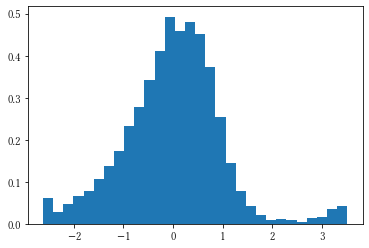

In [40]:
plt.hist(dataset_of_leverage, bins=30, density=True)

In [93]:
deficit_dummy = data['当期利益（百万円）'].apply(
    lambda x: np.nan if np.isnan(x) else 1 if x<= 0 else 0
)
deficit_dummy = deficit_dummy.rename('赤字ダミー')



In [105]:
period = 25 #移動平均の期間を25日にする

group_by_security = data.groupby('SC')  #銘柄ごとに計算

dataset_mv_returns = []
for security, value in group_by_security:
    equity_price = value['時価総額（百万円）']
    moving_average = equity_price.rolling(period).mean()
    moving_average = np.log(equity_price) - np.log(moving_average)
    moving_average.name = f'{period}日移動平均乖離率'
    dataset_mv_returns.append(moving_average)
    


In [106]:
dataset_mv_returns = pd.concat(dataset_mv_returns)

del period

In [110]:
dataset_mv_returns

SC    日時        
1301  2020-12-02         NaN
      2020-12-03         NaN
      2020-12-04         NaN
      2020-12-07         NaN
      2020-12-08         NaN
                      ...   
9997  2021-12-24   -0.030917
      2021-12-27   -0.035903
      2021-12-28   -0.015369
      2021-12-29    0.022555
      2021-12-30    0.015345
Name: 25日移動平均乖離率, Length: 960897, dtype: float64

In [112]:
#25日移動平均乖離率の対数変換、標準化、外れ値
group_by_data = dataset_mv_returns.groupby('日時')

dataset_mv_returns1 = []
for date, value in group_by_data:
    if value.isnull().all(): #グループ後のすべての行、カラムにについてnull判定
        continue
    processed_mv = standardize_characteristics(value)
    processed_mv = trim_outliers(processed_mv)
    processed_mv.name = value.name
    dataset_mv_returns1.append(processed_mv)
    

        

In [163]:
dataset_mv_returns = pd.concat(dataset_mv_returns1)

# マーケットベータ

In [204]:
#1つの銘柄、1つのウィンドウに対してregressionする関数

def calculate_beta_for_one_security_and_period(
    data: pd.DataFrame,
    endog_name,
    exog_names, model
):
    data = data.reset_index()
    security_code = data['SC'].unique()[0]
    end_date = data['SC'].max()
    
    endog = data[endog_name].values
    exog = data[exog_names].values
    
    model.fit(X=exog, y=endog) #線形回帰を行う
    
    #回帰係数を保存。coef_にベータが入っている。
    betas = np.append(model.intercept_,model.coef_)
    
    #求めたベータをDataFrameとして保存
    index = pd.MultiIndex.from_tuples(
        [(security_code, end_date)], names=['SC', ' 日時']
    )
    
    result = pd.DataFrame([betas],
                          columns=['alpha'] + list(exog_names),
                          index=index, dtype='float32')
    return result
    

In [205]:
# window幅125日でrolling regressionする
ROLLING_WINDOW = 125

def run_time_series_regression_on_one_security(
    data_one_security_time_series: pd.DataFrame,
    endog_name,
    exog_names, model
):
    # endof_name + exog_namesカラムがnanであるものを削除
    data_for_estimation = data_one_security_time_series.dropna(
        subset=endog_name + exog_names
    )
    length_data = data_for_estimation.shape[0]
    
    results = []
    #length_data < ROLLING_WINDOWならスキップされる
    for i in range(length_data - ROLLING_WINDOW):
        data = data_for_estimation.iloc[i:ROLLING_WINDOW + i]
        results.append(
            calculate_beta_for_one_security_and_period(
                data,
                endog_name,
                exog_names,
                model
            )
        )
        
    #サンプルサイズがwindow幅より少ないときはNoneを返す
    if not results:
        return None
    
    results = pd.concat(results)
    
    return results

In [206]:
#全銘柄に対してループさせる関数
def run_rolling_regression_over_all_securities(
    data_with_excess_returns,
    endog_name,
    exog_names=None
):
    #endog_name以外のカラムを抽出
    exog_names = exog_names or data_with_excess_returns.columns[
        ~data_with_excess_returns.column.isin(endog_name)
    ]
    
    #これをmodelとして使用する
    model = linear_model.LinearRegression()
    
    group_by_security = data_with_excess_returns.groupby('SC')
    
    results = []
    for security, values in tqdm(group_by_security):
        
        result = run_time_series_regression_on_one_security(
            values,
            endog_name,
            exog_names,
            model
        )
        if result is None:
            continue
        results.append(result)
        
    results = pd.concat(results)
    return results

In [207]:
market_betas = run_rolling_regression_over_all_securities(
    data,
    endog_name=['超過収益率'],
    exog_names=['市場超過収益率']
)

#「市場超過収益率」に対する回帰係数　-> マーケットベータなので名前を変更
market_betas.rename(
    columns={'市場超過収益率':'market_beta'},
    inplace=True
)    


C:/Users/masa/AppData/Local/Temp/xpython_35500/1346331448.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for security, values in tqdm(group_by_security):


  0%|          | 0/3750 [00:00<?, ?it/s]

In [173]:
#業種名も分析用のデータに追加する
industry = data['業種']

In [ ]:
#計算した変数を1つのDataFrameにまとめる
data_for_analysis = pd.concat([
    data[['超過収益率', '市場超過収益率', '収益率', '市場収益率']],
    market_betas,
    dataset_of_firm_size,
    dataset_of_bm,
    dataset_of_leverage,
    dataset_of_price_to_earnings,
    #deficit_dummy,
    #dataset_mv_returns,
    industry

], axis=1)

In [200]:
#計算した変数を1つのDataFrameにまとめる
data_for_analysis = pd.concat([
    data[['超過収益率', '市場超過収益率', '収益率', '市場収益率']].head(),
    #market_betas.head(),
    dataset_of_firm_size.head(),
    dataset_of_bm.head(),
    dataset_of_leverage.head(),
    dataset_of_price_to_earnings.head(),
    deficit_dummy.head(),
    dataset_mv_returns.head(),
    industry.head()

], axis=1)

In [175]:
li = [
data[['超過収益率', '市場超過収益率', '収益率', '市場収益率']],
market_betas,
dataset_of_firm_size,
dataset_of_bm,
dataset_of_leverage,
dataset_of_price_to_earnings,
deficit_dummy,
dataset_mv_returns,
industry
]
for val in li:
    print(type(val))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [208]:
#data[['超過収益率', '市場超過収益率', '収益率', '市場収益率']].head()
market_betas.head()
#dataset_of_firm_size.head()
#print(type(dataset_of_firm_size.head()))
#dataset_of_bm.head()
#dataset_of_leverage.head()
#dataset_of_price_to_earnings.head()
#deficit_dummy.head()
#dataset_mv_returns.head()
#industry.head()

alpha  market_beta
SC    日時                        
1301 1301 -0.000014     0.463435
     1301 -0.000127     0.461814
     1301 -0.000031     0.458829
     1301 -0.000050     0.458995
     1301 -0.000148     0.463677

In [203]:
data[['超過収益率', '市場超過収益率', '収益率', '市場収益率']].head()

超過収益率   市場超過収益率       収益率     市場収益率
SC   日時                                                
1301 2020-12-02  0.008601  0.002710  0.008602  0.002711
     2020-12-03 -0.001401  0.000758 -0.001400  0.000759
     2020-12-04  0.001401  0.000359  0.001402  0.000360
     2020-12-07 -0.000001 -0.008735  0.000000 -0.008734
     2020-12-08  0.001790  0.000043  0.001790  0.000044

In [162]:
#赤字ダミーが1となっている銘柄のE/P ratioをゼロにして赤字ダミーを有効化する
data_for_analysis = data_for_analysis.assign(
    PER=lambda x: np.where(
        data_for_analysis['赤字ダミー'] == 1,
        0,
        data_for_analysis['E(+)/P']
    )
)

<class 'NameError'>: name 'data_for_analysis' is not defined

In [ ]:
#変数を一度保存する
data_for_analysis.to_pickle(f'{DATA_DIR}data_for_analysis_fin.pickle')

In [ ]:
data_for_analysis.to_csv(f'{DATA_DIR}data_for_analysis_fin.csv')

#　株価データを使った線形回帰モデルの作成
銘柄の特徴によって日時リターンのばらつきを説明できるか検証する
→定義してきた説明変数が翌日上がりやすいか下がりやすいか調べる

最小二乗法でデータに最も成語的な回帰係数を計算し線形回帰モデルを作成

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from dateutil.relativedelta import relativedelta

import statsmodels.api as sm

import statmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['font.family'] = 'Yu Mincho'
from IPython.core.display import display
%matplotlib inline

#データの保存場所を指定
#この場合は、C:/sample/linear_regression/を読み書きする
WORK_DIR = 'C:/sample/linear_regression/'
DATA_DIR = 'C:/sample/linear_regression/data/'

#2.2.1で作ったデータを読み込む
data_for_analysis_loaded = pd.read_pickle(
    f'{DATA_DIR}data_for_analysis_fin.pickle'
)

In [ ]:
independent_variables_names = [
    'market_beta', '企業規模', '簿価時価比率', '財務レバレッジ',
    '赤字ダミー', '25日移動平均乖離率', 'PER'
]
column_to_use = [
    '業種', '翌日収益率', '翌日超過収益率', '収益率', '市場収益率'
] + independent_variables_names

data_for_analysis = data_for_analysis_loaded.assign(
    #超過収益率を1日分ずらして、Y_iを作成
    翌日超過収益率=lambda x: x['超過収益率'].groupby(lebel=0).shift(-1),
    #後のシミュレーションで利用するので一緒に作成しておく
    翌日収益率=lambda x:x['超過率'].groupby(level=0).shift(-1)
    
)[columns_to_use]

In [ ]:
#証券コードごとに5つずつ表示して、計算結果を確認
data_for_analysis.dropna(
    subset=independent_variables_names
).groupby(level=0).head()

日本市場において金融業の財務データの意味が大きく異なるため分析対象外とする

In [ ]:
exclude_fin = data_for_analysis[
    data_for_analysis['業種'].apply(
        lambda x: x not in['銀行', '証券・先物', '保険', 'その他金融']
    )
]

In [ ]:
#2016年7月6日のデータを取得
data_tmp = exclude_fin.dropna(
    subset=independent_variables_names
).xs(pd.datetime(2016,7,6),level=1)
exog = sm.add_constant(data_tmp[independent_variables_names])
endog = data_tmp['翌日超過収益率']
sm.OLS(endog, exog).fit().summary()

In [ ]:
#2017年7月6日のデータを取得
data_tmp = exclude_fin.dropna(
    subset=independent_variables_names
).xs(pd.datetime(2016,7,6),level=1)
exog = sm.add_constant(data_tmp[independent_variables_names])
endog = data_tmp['翌日超過収益率']
sm.OLS(endog, exog).fit().summary()